# Lesson 07 Assignment - SVM - Classification and Regression

## Dataset and Task

Use abalone (marine snails) data to classify and determine the age from physical characteristics.

According to the data provider, original data examples with missing values were removed, and the ranges of the continuous values have been scaled (by dividing by 200).

The target field is “Rings”. Since the output is continuous the solution can be handled by a Support Vector Regression or it can be changed to a binary Support Vector Classification by assigning examples that are younger than 11 years old to class: ‘0’ and those that are older (class: ‘1’).

See <a href='https://archive.ics.uci.edu/ml/datasets/abalone'>UCI's Abalone Data set</a> for more information.

## Instructions

Using the <a href='https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Abalone.csv'>Abalone csv</a> file,  create a new notebook to build an experiment using support vector machine classifier and regression. Perform each of the following tasks and answer the questions:

1. Convert the continuous output value from continuous to binary (0,1) and build an SVC
2. Using your best guess for hyperparameters and kernel, what is the percentage of correctly classified results?
3. Test different kernels and hyperparameters or consider using sklearn.model_selection.SearchGridCV. Which kernel performed best with what settings?
4. Show recall, precision and f-measure for the best model
5. Using the original data, with rings as a continuous variable, create an SVR model
6. Report on the predicted variance and the mean squared error

In [1]:
import pandas as pd
import numpy as np

from collections import Counter
from itertools import combinations

from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline

## Load and prepare data

In [2]:
def load_data(a_url, path, header):
    """Return a DataFrame containing a dataset from url or local path."""
    print('Trying to load the data set from a local file if it exists...')
    try:
        data_set = pd.read_csv(path, header = header)
    except FileNotFoundError:
        print('\tFile not found, loading from Internet...')
        data_set = pd.read_csv(a_url, header = header)
        print('\t\tData loaded from url')
    else:
        print('\tData loaded from local file')
    
    return data_set

In [3]:
url_data = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Abalone.csv'
local_path_data = './Abalone.csv'

data = load_data(url_data, local_path_data, 0)

print('Data shape:', data.shape)
print(data.nunique())
print(data.dtypes)
print(data.head())

Trying to load the data set from a local file if it exists...
	Data loaded from local file
Data shape: (4177, 9)
Sex                  3
Length             134
Diameter           111
Height              51
Whole Weight      2429
Shucked Weight    1515
Viscera Weight     880
Shell Weight       926
Rings               28
dtype: int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Rings               int64
dtype: object
  Sex  Length  Diameter  Height  Whole Weight  Shucked Weight  Viscera Weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330 

In [4]:
# Any missing values?
data.isnull().sum().any()

False

In [5]:
data.describe()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


## Plot the data - many highly correlated features

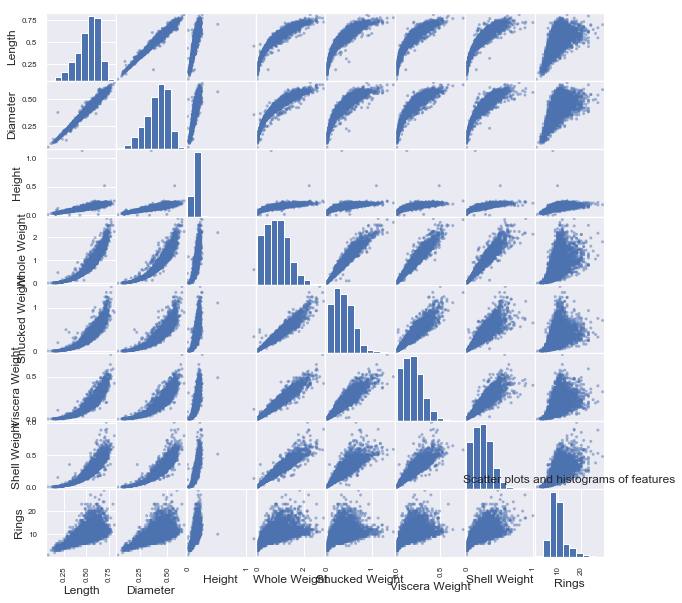

In [6]:
pd.plotting.scatter_matrix(data, figsize=(10, 10))
plt.title('Scatter plots and histograms of features')
plt.show()

In [7]:
print('Data correlation matrix')
data.corr()

Data correlation matrix


,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole Weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked Weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera Weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell Weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


In [8]:
def calc_MI(x, y, bins):
    """Return a mutual information score for two features."""
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [9]:
current_columns = list(data[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight']].columns)
# All possible combinations of columns by using itertools
column_combinations = combinations(current_columns, 2)

# List of columns with high mutual information score - I chose 0.6 as a threshold
mutual_info_columns_pairs = []
for column_pair in column_combinations:
    column_one = column_pair[0]
    column_two = column_pair[1]
    mi = calc_MI(data[column_one], 
                 data[column_two], 20)
    if mi > 1.4:
        mutual_info_columns_pairs.append((column_one, column_two))

In [10]:
print('Number of pairs of features with high mutual information score identified:')
print(len(mutual_info_columns_pairs))
print(mutual_info_columns_pairs)

Number of pairs of features with high mutual information score identified:
2
[('Length', 'Diameter'), ('Diameter', 'Whole Weight')]


Example of pairs of highly correlated features


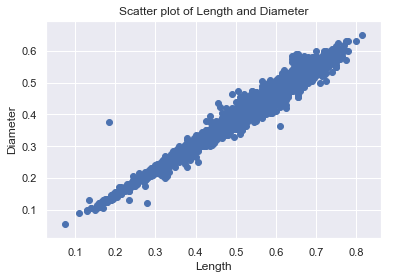

Mutual information score = 1.607
Correlation coefficient =  0.987


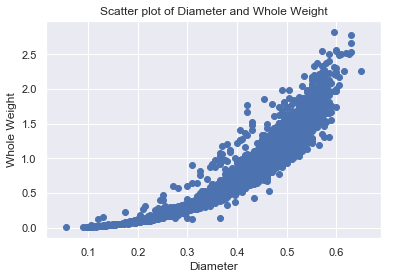

Mutual information score = 1.401
Correlation coefficient =  0.925


In [11]:
# Plot the first two pair of features with mutual information score above 1.1
print('Example of pairs of highly correlated features')
for col_pair in mutual_info_columns_pairs:
    column_one, column_two = col_pair
    plt.scatter(data[column_one], data[column_two])
    plt.title('Scatter plot of {} and {}'.format(column_one, column_two))
    plt.xlabel(column_one)
    plt.ylabel(column_two)
    plt.show()
    mi= calc_MI(data[column_one], data[column_two], 20)
    print('Mutual information score =', round(mi, 3))
    corr_coef = np.corrcoef(data[column_one], data[column_two])[0][1]
    print('Correlation coefficient = ', round(corr_coef, 3))

## Removal of highly correlated features - every additional correlated feature removed leads to a worse classification performance 

In [12]:
# If any columns are removed, also change cell 20

In [13]:
# def choose_lower_mi(X_dataframe, Y_data, a_tuple):
#     """Return one of two column names in a_tuple with a lower MI score with Y label."""
#     col_num0 = a_tuple[0]
#     col_num1 = a_tuple[1]
#     mi0 = calc_MI(X_dataframe[col_num0], Y_data, 20)
#     mi1 = calc_MI(X_dataframe[col_num1], Y_data, 20)
#     if mi0 <= mi1:
#         return col_num0
#     return col_num1

In [14]:
# print('Number of pairs of features with high mutual information score identified:')
# print(len(mutual_info_columns_pairs))
# print(mutual_info_columns_pairs)
# mi_based_columns_to_drop = set()
# for feature_pair in mutual_info_columns_pairs:
#     mi_based_columns_to_drop.add(choose_lower_mi(data, data['Rings'], feature_pair))
# print('Number and names of features with a high MI score to be removed:')
# print(len(mi_based_columns_to_drop))
# print(mi_based_columns_to_drop)

# # Drop columns with high mutual information score
# data = data.drop(mi_based_columns_to_drop, axis = 1)
# print('Data shape after removing features with a high mutual correlation score',
#       data.shape)
# data.corr()
# # with mi=1.1, removed 5 features
# # wth mi=1.5, removed 1 feature

## Plot the distribution of the categorical feature 'Sex'

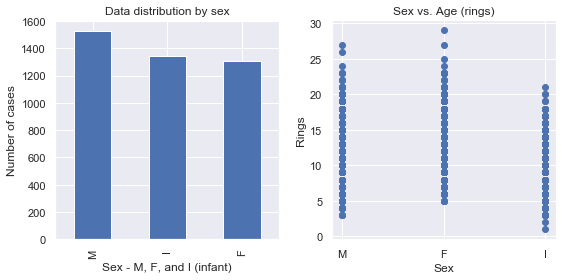

In [15]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
data['Sex'].value_counts().plot(ax = ax0, kind = 'bar', color = 'C0')
ax0.set_title('Data distribution by sex')
ax0.set_ylabel('Number of cases')
ax0.set_xlabel('Sex - M, F, and I (infant)')

ax1.scatter(data['Sex'], data['Rings'])
ax1.set_title('Sex vs. Age (rings)')
ax1.set_xlabel('Sex')
ax1.set_ylabel('Rings')

plt.tight_layout()
plt.show()

## Plot the distribution of the target variable

Text(0, 0.5, 'Number of cases')

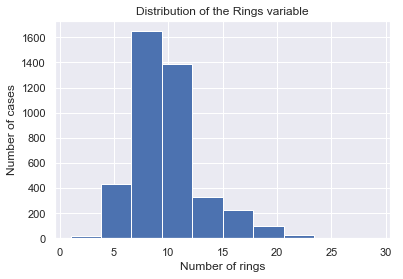

In [16]:
data['Rings'].hist()
plt.title('Distribution of the Rings variable')
plt.xlabel('Number of rings')
plt.ylabel('Number of cases')

## Apply one-hot encoding to the 'Sex' variable (with 3 states - M, F, and I (infant))

In [17]:
# One hot encode 'Sex'
sex_dummies_df = pd.get_dummies(data['Sex'], prefix = 'sex')
sex_dummies_df.columns.values

array(['sex_F', 'sex_I', 'sex_M'], dtype=object)

In [18]:
# Add one-hot-encoded 'Sex' columns to the dataset
data[sex_dummies_df.columns.values] = sex_dummies_df
data.head()

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings,sex_F,sex_I,sex_M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [19]:
data.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Rings', 'sex_F', 'sex_I', 'sex_M'],
      dtype='object')

In [20]:
# Skip the 'Sex' column and move 'Rings' column to the end
data = data[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'sex_F', 'sex_I', 'sex_M', 'Rings']]
data.head()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,sex_F,sex_I,sex_M,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0,7


## Convert the continuous output value from continuous to binary (0,1)

Assign examples that are younger than 11 years old to class: ‘0’ and those that are older (class: ‘1’)

In [21]:
lt_11_mask = data['Rings'] < 11
ge_11_mask = data['Rings'] >= 11
data.loc[lt_11_mask, 'Ring_Bins'] = 0
data.loc[ge_11_mask, 'Ring_Bins'] = 1
data.head()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,sex_F,sex_I,sex_M,Rings,Ring_Bins
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1,15,1.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1,7,0.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0,9,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1,10,0.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0,7,0.0


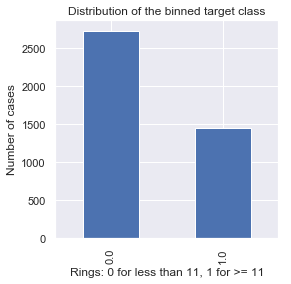

In [22]:
fig = plt.figure(figsize = (4, 4))
data['Ring_Bins'].value_counts().plot(kind = 'bar', color = 'C0')
plt.title('Distribution of the binned target class')
plt.xticks([0, 1])
plt.xlabel('Rings: 0 for less than 11, 1 for >= 11')
plt.ylabel('Number of cases')
plt.show()

## Split data into training and testing

In [23]:
# Split data into training and testing sets
feature_names = data.columns[:-2]
X = data[feature_names]
Y = data['Ring_Bins']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 99)

Original train dataset shape Counter({0.0: 2189, 1.0: 1152})
Original test dataset shape Counter({0.0: 541, 1.0: 295})


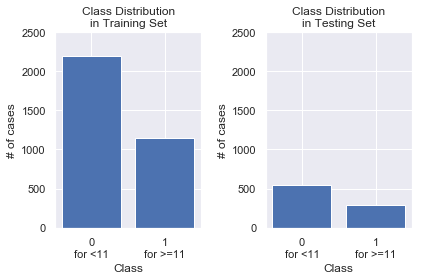

In [24]:
print('Original train dataset shape {}'.format(Counter(y_train)))
print('Original test dataset shape {}'.format(Counter(y_test)))

fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2)

def plot_bar_class(axis, data, title):
    """Plot a sub-plot."""
    axis.bar(Counter(data).keys(), Counter(data).values())
    axis.set_xlabel('Class')
    axis.set_ylabel('# of cases')
    axis.set_ylim(0, 2500)
    axis.set_title(title)
    axis.set_xticks([0, 1])
    axis.set_xticklabels(['0\nfor <11', '1\nfor >=11'])

plot_bar_class(ax0, Counter(y_train), 'Class Distribution\nin Training Set')
plot_bar_class(ax1, Counter(y_test), 'Class Distribution\nin Testing Set')

plt.tight_layout()
plt.show()

## Build SVC using your best guess for hyperparameters and kernel, what is the percentage of correctly classified results?

In [25]:
# Test LinearSVC - similar to SVC with kernel=’linear’
lin_clf = svm.LinearSVC(class_weight = 'balanced').fit(X_train, y_train)
lin_clf_pred = lin_clf.predict(X_test)
print("LinearSVC")
print(classification_report(y_test, lin_clf_pred))

LinearSVC
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82       541
         1.0       0.66      0.72      0.69       295

   micro avg       0.77      0.77      0.77       836
   macro avg       0.75      0.76      0.75       836
weighted avg       0.77      0.77      0.77       836



In [26]:
print('Linear SVC confusion matrix')
lin_clf_conf_matrix_obj = confusion_matrix(y_test, lin_clf_pred)
conf_matrix_lin_clf = pd.DataFrame(lin_clf_conf_matrix_obj,
                                    columns = ['Predicted 0', 'Predicted 1'],
                                    index = ['True 0', 'True 1']
                                   )
conf_matrix_lin_clf

Linear SVC confusion matrix


,Predicted 0,Predicted 1
True 0,431,110
True 1,84,211


In [27]:
# Generate the accuracy score for the linear SVC on testing data
acc_lin_svc = accuracy_score(y_test, lin_clf_pred) * 100
print("Linear SVC accuracy on testing data is: {:.2f}%".format(acc_lin_svc))

Linear SVC accuracy on testing data is: 76.79%


## Test different kernels and hyperparameters or consider using sklearn.model_selection.SearchGridCV. Which kernel performed best with what settings?

In [28]:
# # Search for optimal model parameters

# # C_range = np.logspace(-3, 3, num = 5)
# # gamma_range = np.logspace(-3, 3, num = 5)
# sv_parameters = {'C': [0.01, 10, 100, 1000],
#                  'kernel': ['linear', 'rbf', 'poly'],  # omitted 'sigmoid', 'linear',
#                  'degree': [3, 4],  # Degree for ‘poly’
# #                  'gamma': gamma_range,
# #                  'class_weight': ['balanced'],  # None
#                 }
# svc = svm.SVC(gamma='scale', class_weight='balanced')
# gridsearch_sv_clf = GridSearchCV(svc, sv_parameters, cv = 5)  # 'cv=5' for cross validation
# gridsearch_sv_clf.fit(X_train, y_train)
# gridsearch_sv_clf.best_params_

# OUTPUT:
# {'C': 1000, 'degree': 4, 'kernel': 'poly'}

### Grid Search seems to run forever -- Split the testing set into valiadation and testing sets

In [29]:
# x_val, x_new_test, y_val, y_new_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 99)

In [30]:
# # LINEAR vs RBF
# for k in ('linear', 'rbf'):
#     for cost in (1, 10, 100, 1000):
#         for gamma in (0.001, 1.0, 1000.0):
#             clf = svm.SVC(gamma=gamma, kernel=k, C=cost, class_weight = 'balanced').fit(X_train, y_train)
#             y_pred = clf.predict(x_val)
#             print(k, 'gamma=', gamma, 'C=', cost)
#             print(classification_report(y_val, y_pred))

In [31]:
# # POLY
# for cost in (100, 1000, 2000):
#     for degree in (4, 5):
#         clf = svm.SVC(gamma='scale', 
#                       kernel='poly',
#                       C=cost,
#                       class_weight = 'balanced',
#                       degree = degree
#                      ).fit(X_train, y_train)
#         y_pred = clf.predict(x_val)
#         print('degree=', degree, 'C=', cost)
#         print(classification_report(y_val, y_pred))

## Show recall, precision and f-measure for the best model

In [32]:
poly_clf = svm.SVC(gamma = 'scale',
                   kernel = 'poly',
                   C = 1000,
                   class_weight = 'balanced',
                   degree = 4,
                   probability = True
                  ).fit(X_train, y_train)
poly_clf_pred = poly_clf.predict(X_test)
print("PolySVC model report")
print(classification_report(y_test, poly_clf_pred))

PolySVC model report
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82       541
         1.0       0.67      0.75      0.70       295

   micro avg       0.78      0.78      0.78       836
   macro avg       0.76      0.77      0.76       836
weighted avg       0.79      0.78      0.78       836



In [33]:
print('Poly SVC confusion matrix')
poly_clf_conf_matrix_obj = confusion_matrix(y_test, poly_clf_pred)
conf_matrix_poly_clf = pd.DataFrame(poly_clf_conf_matrix_obj,
                                    columns = ['Predicted 0', 'Predicted 1'],
                                    index = ['True 0', 'True 1']
                                   )
conf_matrix_poly_clf

Poly SVC confusion matrix


,Predicted 0,Predicted 1
True 0,430,111
True 1,74,221


In [34]:
# Generate the accuracy score for the linear SVC on testing data
acc_poly = accuracy_score(y_test, poly_clf_pred) * 100
print("Poly SVC accuracy on testing data is: {:.2f}%".format(acc_poly))

Poly SVC accuracy on testing data is: 77.87%


In [35]:
def do_roc_analysis(XX, YY, model, plot = True):
    """Return area under curve metric and prob. estimates; plot ROC curve."""
    # y = probability estimates of the positive class
    #  [:,1] for predicted probabilities for the positive label only
    y = model.predict_proba(XX.values)[:, 1]
    LW = 1.5  # line width for plots
    LL = "lower right"  # legend location
    LC = "darkgreen"  # Line Color
    # False Positive Rate, True Posisive Rate, probability thresholds
    fpr, tpr, th = metrics.roc_curve(YY.astype(int), y)
    print('First 10 or less prob.thresholds:', np.round(th[:10], 3))
    AUC = metrics.auc(fpr, tpr)
    print('AUC: {:.3f}'.format(AUC))

    if plot:
        plt.figure()
        plt.title('ROC curve, {} Model'.format(type(model)))
        plt.xlim([-0.1, 1.0])
        plt.ylim([-0.1, 1.05])
        plt.xlabel('FALSE Positive Rate')
        plt.ylabel('TRUE Positive Rate')
        plt.plot(fpr, tpr, color=LC, lw=LW,
                 label='ROC curve (area = %0.2f)' % AUC)
        plt.plot(fpr, tpr, 'bo',
                 label='ROC curve (area = %0.2f)' % AUC, alpha = 0.2)
        # reference line for random classifier
        plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--')
        plt.legend(loc=LL)
        plt.show()

    return AUC, y


ROC curve for the Poly SVC model
First 10 or less prob.thresholds: [2.    1.    0.907 0.904 0.89  0.89  0.871 0.865 0.852 0.848]
AUC: 0.863


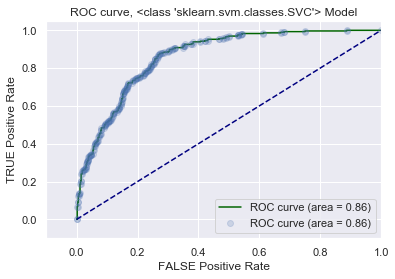

In [36]:
print("\nROC curve for the Poly SVC model")
_, _ = do_roc_analysis(X_test, y_test, poly_clf)

## Using the original data, with rings as a continuous variable, create an SVR model

In [37]:
# Split data into training and testing sets
feature_names = data.columns[:-2]
X = data[feature_names]
Y = data['Rings']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 99)

In [38]:
# sv_parameters = {'C': [0.01, 10, 100, 1000],
#                  'kernel': ['linear', 'rbf', 'poly'],  # omitted 'sigmoid', 'linear',
#                  'degree': [3, 4],  # Degree for ‘poly’
# #                  'gamma': gamma_range,
# #                  'class_weight': ['balanced'],  # None
#                 }
# svc = svm.SVC(gamma='scale', class_weight='balanced')
# gridsearch_sv_clf = GridSearchCV(svc, sv_parameters, cv = 5)  # 'cv=5' for cross validation
# gridsearch_sv_clf.fit(X_train, y_train)
# gridsearch_sv_clf.best_params_

In [39]:
# param_grid = {"C": (1e0, 1e1, 1e2, 1e3),
#               "gamma": np.logspace(-2, 2, 5),
#               'epsilon': (.01, 0.1, 0.2)
#              }
# svr = GridSearchCV(svm.SVR(kernel='rbf', gamma='auto'), 
#                    cv=5,
#                    param_grid=param_grid)
# svr.fit(X_train, y_train)
# svr.best_params_

In [40]:
# Define the model
svr_rbf = svm.SVR(kernel='rbf', C=100, gamma='auto')

In [41]:
def print_scores(X_train, y_train, model):
    y_true = y_test
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    svr_r2 = model.score(X_test, y_true)
    print('SVR with {} kernel'.format(model.__dict__['kernel']))
    print('R^2: {:.2f}'.format(svr_r2))
    mse = metrics.mean_squared_error(y_true, y_pred)
    print('MSE: {:.2f}'.format(mse))

print_scores(X_train, y_train, svr_rbf)

SVR with rbf kernel
R^2: 0.56
MSE: 4.30


## Summary

The dataset contains many highly correlated features. I attempted to remove some of such features one by one, but that leads to a worse performance.

<b>1. Using your best guess for hyperparameters and kernel, what is the percentage of correctly classified results?</b>

With the <b>LinearSVC</b> classifier, with class_weight=‘balanced’, and all other parameters being default, the model’s accuracy on the testing data is <b>76.79%</b>. 

LinearSVC model report:

| class  |  precision |   recall | f1-score|
|--------|------------|----------|---------|
|    0.0 |      0.84  |    0.80  |    0.82 |
|   1.0  |     0.66   |   0.72   |   0.69  |

<b>2. Test different kernels and hyperparameters or consider using sklearn.model_selection.SearchGridCV. Which kernel performed best with what settings?</b>

I was able to perform only a very limited grid search for SVC models because the process is very slow. I achieved an accuracy of <b>77.87%</b> compared to LinearSVC by using an SVC model with the following parameters: kernel = 'poly’, gamma = 'scale’, C = 1000, class_weight = 'balanced', degree = 4.

<b>3. Show recall, precision and f-measure for the best model</b>

PolySVC model report:

| class  |  precision |   recall | f1-score|
|--------|------------|----------|---------|
|    0.0 |      0.85  |    0.79  |    0.82 |
|    1.0 |      0.67  |    0.75  |    0.70 |

<b>4. Report on the predicted variance and the mean squared error with rings as a continuous variable, and an SVR model</b>

For an SVR model with kernel='rbf', C=100, gamma='auto’, the <b>r-squared</b> is <b>0.56</b> and <b>MSE</b> is <b>4.3</b>.